# Context #
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Content #
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

During this exercise I would like to compare 2 methodologies once the train_test split is carried out:

    1. Over and undersampling on scaled dataset and then machine learning prediction
    2. Stratified Kfold - resampling during cross validation and then machine learning prediction


I will focus on precision and recall evaluation metrics, since accuracy is not reliable in case of imbalanced datasets.



## I. Data collection

In [1]:
#pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 16.5 MB/s eta 0:00:00


In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


In [3]:
#data = pd.read_csv(r"C:\Users\lily\Desktop\IT alapok privát\PORTFOLIO PROJECT\creditcard.csv")

In [4]:
data = pd.read_csv("/content/creditcard.csv")

In [5]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13949,24754,1.252924,-0.182189,-0.802716,-0.210981,1.916713,3.643624,-0.778711,0.818295,1.706962,...,-0.497088,-1.211285,0.043809,0.964159,0.442030,0.261483,-0.051402,0.005112,23.74,0.0
13950,24756,-0.346979,-2.103284,-0.685061,1.961605,-0.401125,0.473632,1.133816,-0.256528,0.893409,...,0.359662,-0.316275,-0.864259,-0.279881,0.491802,-0.353996,-0.149931,0.129795,794.20,0.0
13951,24759,-6.053652,-5.988723,0.810413,-0.011811,1.308135,-0.590803,-0.725838,-0.234840,1.624646,...,-0.771970,1.474668,3.176363,-0.302410,0.052529,-0.373871,-0.700463,2.508443,60.00,0.0
13952,24759,1.169121,-1.284945,0.032717,-0.681670,0.660598,4.412578,-1.913115,1.076592,1.501230,...,-0.557596,-0.882435,-0.041523,0.975445,0.297229,0.550515,0.015029,0.032067,90.00,0.0


*Observation: Amount and Time : scaling will be needed , V1-V28 values are scaled (between 0 and 1)*

## II. Exploratory data analysis

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13954 entries, 0 to 13953
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    13954 non-null  int64  
 1   V1      13954 non-null  float64
 2   V2      13954 non-null  float64
 3   V3      13954 non-null  float64
 4   V4      13954 non-null  float64
 5   V5      13954 non-null  float64
 6   V6      13954 non-null  float64
 7   V7      13954 non-null  float64
 8   V8      13954 non-null  float64
 9   V9      13954 non-null  float64
 10  V10     13954 non-null  float64
 11  V11     13954 non-null  float64
 12  V12     13954 non-null  float64
 13  V13     13954 non-null  float64
 14  V14     13954 non-null  float64
 15  V15     13954 non-null  float64
 16  V16     13954 non-null  float64
 17  V17     13954 non-null  float64
 18  V18     13954 non-null  float64
 19  V19     13954 non-null  float64
 20  V20     13954 non-null  float64
 21  V21     13954 non-null  float64
 22

In [7]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    1
Class     1
dtype: int64

*Observation: Since there are only some missing values, we can drop them.*

In [8]:
data.dropna(inplace=True)

<Axes: xlabel='Class', ylabel='count'>

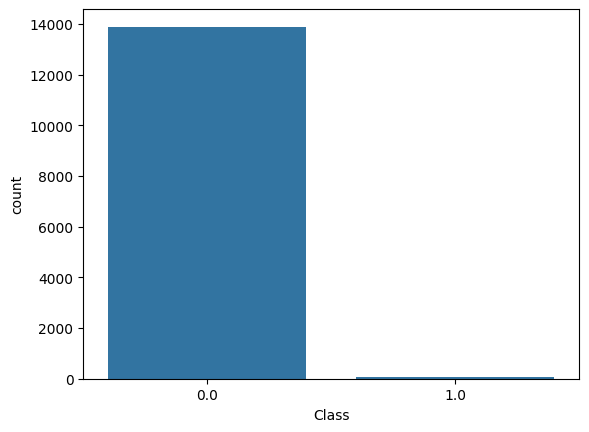

In [9]:
sns.countplot(data, x=data['Class'])

*Observation: Highly imbalanced dataset - majority of the class is 0 which are the non-freud ones.*

In [10]:
freud = data[data['Class']==1]

In [11]:
freud.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1.0
623,472,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1.0
4920,4462,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1.0
6108,6986,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1.0
6329,7519,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1.0


*Average amount freuded*

In [12]:
freud['Amount'].mean()

90.81589285714287

*Total amount freuded*

In [13]:
freud['Amount'].sum()

5085.6900000000005

In [14]:
data['Class'].value_counts()

Class
0.0    13897
1.0       56
Name: count, dtype: int64

In [15]:
class_0 = data[data['Class']==0]
class_1 = data[data['Class']==1]

In [16]:
print(class_0.shape)

(13897, 31)


In [17]:
print(class_1.shape)

(56, 31)


#### Outlier check

<Axes: ylabel='Amount'>

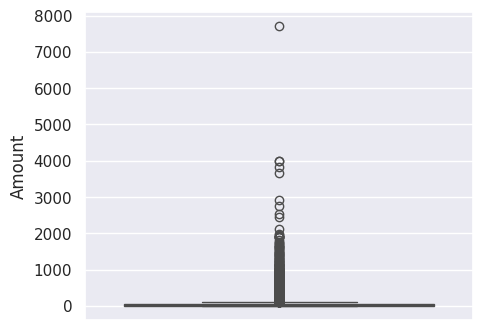

In [18]:
sns.set(rc={"figure.figsize":(5,4)})
sns.boxplot(y=data['Amount'])

In [19]:
data['Amount'].describe()

count    13953.000000
mean        63.882442
std        177.887021
min          0.000000
25%          5.490000
50%         15.690000
75%         52.150000
max       7712.430000
Name: Amount, dtype: float64

*Observation: Plenty of outliers needs to be handled.*

In [20]:
non_outlier_condition = (
    (data['Amount'] < data['Amount'].quantile(0.95)))

In [21]:
data = data[non_outlier_condition]

<Axes: ylabel='Amount'>

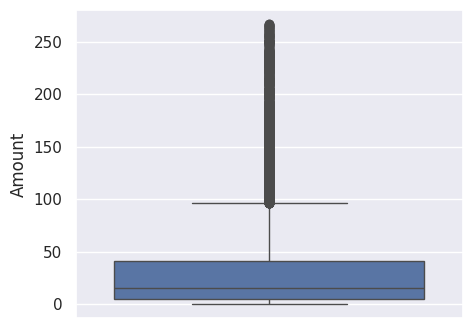

In [22]:
sns.boxplot(y=data['Amount'])

<Axes: ylabel='Time'>

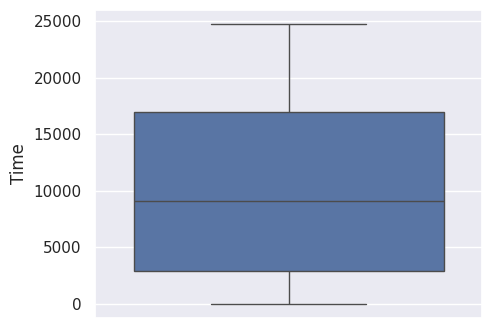

In [23]:
sns.boxplot(y=data['Time'])

*Comment: For time feature no outlier removal is needed*

## III. Model building & selection

#### 1. Resampling, scaling and machine learning prediction without cross validation

Note: Drawbacks of the two

Undersampling - Random Under Sampler:

Loss of Information:Random undersampling involves discarding instances from the majority class randomly. This can lead to a significant loss of information and may discard potentially important examples. Reduced Model Performance:In scenarios where the majority class contains valuable information, random undersampling might reduce the overall performance of the model by removing relevant instances.

Oversampling - SMOTE:

Overfitting to Synthetic Examples:The synthetic examples generated by SMOTE might lead to overfitting if the model relies too heavily on these artificial instances. Sensitive to Noisy Data: SMOTE can be sensitive to noisy examples, and the generation of synthetic instances might be influenced by noisy data points in the minority class.

In [24]:
X = data.drop('Class', axis=1)
y = data['Class']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [26]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [27]:
pipe01 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

*Comment: the pipeline automatically applies fit_transform during training and transform during testing for steps that require it (like scaling), ensuring consistent preprocessing across both training and test data.*

In [28]:
pipe01.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [29]:
y_pred01 = pipe01.predict(X_test)

In [30]:
pipe01.score(X_test, y_test)

0.9987929993964997

In [31]:
X = data.drop('Class', axis=1)
y = data['Class']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [33]:
under_sampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

In [34]:
pipe02 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [35]:
pipe02.fit(X_train_resampled, y_train_resampled)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [36]:
y_pred02 = pipe01.predict(X_test)

In [37]:
f1 = f1_score(y_test, y_pred02)

print("F1-score:", f1)

F1-score: 0.8823529411764706


Checking for overfitting

In [38]:
train_accuracy = accuracy_score(y_train_resampled, pipe02.predict(X_train_resampled))

# Calculate accuracy on test set
test_accuracy = accuracy_score(y_test, y_pred02)

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Check for overfitting
if train_accuracy > test_accuracy:
    print("The model might be overfitting.")
else:
    print("The model is not overfitting.")

Training Accuracy: 1.0
Test Accuracy: 0.9987929993964997
The model might be overfitting.


In [39]:
pipe02.score(X_test, y_test)

0.9966807483403741

*Comment

In [40]:
# rf_01 = RandomForestClassifier(n_estimators=50, random_state=42)
# logreg_01 = LogisticRegression(C=100, max_iter=100)
# grb_01 = GradientBoostingClassifier(n_estimators=50)

In [41]:
# def train_and_eval(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     y_pred_01 = model.predict(X_test)
#     #accuracy = accuracy_score(y_test, y_pred_01,)
#     report_01 = classification_report(y_test, y_pred_01)
#     matrix_01 = confusion_matrix(y_test, y_pred_01)
#     cmap = sns.color_palette(palette='PiYG')
#     sns.heatmap(matrix_01, annot=True, cmap=cmap)


#     print(f' Classification report for model {model}:\n\n{report_01}\n')

##### 2. Stratified Kfold - resampling during cross validation and then machine learning prediction

In [72]:
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42),
    'SVM': SVC(C=1, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5, weights='uniform'),
    'Logreg': LogisticRegression(C=100, max_iter=1000),
    'Gradient': GradientBoostingClassifier(n_estimators=50),
    'XGBoost': XGBClassifier(learning_rate=0.1, max_depth=3, random_state=42)
}

#'Catboost': CatBoostClassifier(learning_rate=0.1, depth=6, random_state=42)
#'LightGBM': lgb.LGBMClassifier(learning_rate=0.1, max_depth=5,num_leaves=31, random_state=42

In [73]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

*Comment: StratifiedKFold is initialized outside the loop to ensure consistent cross-validation We import.*

In [74]:
steps = [
    ('scaler', StandardScaler()),
    ('classifier', None)  # Placeholder for classifier
]

In [81]:
for name, clf in classifiers.items():
    steps[-1] = ('classifier', clf)
    pipeline = ImbPipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
        ('pipeline', Pipeline(steps))
    ])
    precision_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='precision')
    print(f"{name} Mean Precision: {precision_scores.mean():.4f} (+/- {precision_scores.std() * 2:.4f})")

    recall_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')
    print(f"{name} Mean Recall: {recall_scores.mean():.4f} (+/- {recall_scores.std() * 2:.4f})")

    f1_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1')
    print(f"{name} Mean F1: {f1_scores.mean():.4f} (+/- {f1_scores.std() * 2:.4f})")

Random Forest Mean Precision: 0.9714 (+/- 0.1143)
Random Forest Mean Recall: 0.8524 (+/- 0.0190)
Random Forest Mean F1: 0.9071 (+/- 0.0511)
SVM Mean Precision: 0.9429 (+/- 0.2286)
SVM Mean Recall: 0.7952 (+/- 0.1333)
SVM Mean F1: 0.8606 (+/- 0.1608)
KNN Mean Precision: 0.7790 (+/- 0.2478)
KNN Mean Recall: 0.8810 (+/- 0.2172)
KNN Mean F1: 0.8218 (+/- 0.1849)
Logreg Mean Precision: 0.5875 (+/- 0.2837)
Logreg Mean Recall: 0.7619 (+/- 0.1594)
Logreg Mean F1: 0.6460 (+/- 0.1228)
Gradient Mean Precision: 0.8650 (+/- 0.2482)
Gradient Mean Recall: 0.8857 (+/- 0.3332)
Gradient Mean F1: 0.8529 (+/- 0.1498)
XGBoost Mean Precision: 0.9667 (+/- 0.1333)
XGBoost Mean Recall: 0.9143 (+/- 0.2286)
XGBoost Mean F1: 0.9385 (+/- 0.1794)


*Comment: ImbPipeline imported from imblearn.pipeline to handle resampling techniques like SMOTE within the pipeline and SMOTE is applied within the pipeline to ensure it's applied separately to each fold of the training data*

XGBoost Mean F1: 0.9278 (+/- 0.1019)

Random Forest Mean F1: 0.9044 (+/- 0.1076)

Gradient Mean F1: 0.8769 (+/- 0.1441)

In [47]:
classifiers02 = {
  'Catboost': CatBoostClassifier(random_state=42),
  'LightGBM': lgb.LGBMClassifier(random_state=42)
}

In [ ]:
for name, clf in classifiers02.items():
    steps[-1] = ('classifier', clf)
    pipe = Pipeline(steps)
    pipeline = ImbPipeline([
        ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
        ('pipeline', Pipeline(steps))
    ])
    precision_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='precision')
    print(f"{name} Mean Precision: {precision_scores.mean():.4f} (+/- {precision_scores.std() * 2:.4f})")

    recall_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='recall')
    print(f"{name} Mean Recall: {recall_scores.mean():.4f} (+/- {recall_scores.std() * 2:.4f})")

    f1_scores = cross_val_score(pipeline, X, y, cv=skf, scoring='f1')
    print(f"{name} Mean F1: {f1_scores.mean():.4f} (+/- {f1_scores.std() * 2:.4f})")


Catboost Mean F1: 0.9161 (+/- 0.1036)

LightGBM Mean F1: 0.8179 (+/- 0.1253)
```
# Ez kódként van formázva
```



##    VI. Hyperparameter tuning & model selection

### RandomForest & Random search

In [82]:
rf = RandomForestClassifier()

In [63]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [64]:
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [65]:
random_search = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=skf,
                                   scoring=scoring,
                                   refit='f1',
                                   random_state=42)

In [66]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_estimators=50,
                                                    random_state=42),
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, refit='f1',
                   scoring={'f1': make_scorer(f1_score),
                            'precision': make_scorer(precision_score),
                            'recall': make_scorer(recall_score)})

In [67]:
best_params = random_search.best_params_
best_score = random_search.best_score_

*Comment: The best score reported by random_search.best_score_ corresponds to the average score across all classes, weighted by the number of samples in each class.*

In [68]:
print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Best Score: 0.907092907092907


In [83]:
rf01 = RandomForestClassifier(n_estimators=100, min_samples_split= 2, min_samples_leaf=1, max_depth = 10, random_state=42)

In [96]:
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),  # SMOTE applied within the pipeline
    ('classifier', rf01)
])

In [97]:
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [98]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [99]:
precision_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='precision')
recall_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='recall')
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1')

In [91]:
print("Mean Precision:", precision_scores.mean())
print("Mean Recall:", recall_scores.mean())
print("Mean F1 Score:", f1_scores.mean())

Mean Precision: 0.9714285714285715
Mean Recall: 0.8523809523809524
Mean F1 Score: 0.907092907092907


In [102]:
rf01.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [103]:
y_pred_rf01 = rf01.predict(X_test)

 Classification report for rf_01 :

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3296
         1.0       1.00      0.94      0.97        18

    accuracy                           1.00      3314
   macro avg       1.00      0.97      0.99      3314
weighted avg       1.00      1.00      1.00      3314




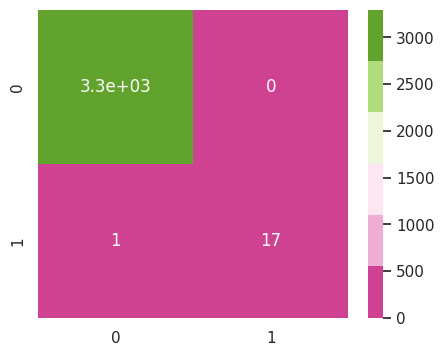

In [104]:
report_rf01 = classification_report(y_test, y_pred_rf01)
matrix_rf01 = confusion_matrix(y_test, y_pred_rf01)
cmap = sns.color_palette(palette='PiYG')
sns.heatmap(matrix_rf01, annot=True, cmap=cmap)
print(f' Classification report for rf_01 :\n\n{report_rf01}\n')

For class 0, the precision is 1.00, which means all samples predicted as class 0 are truly class 0. For class 1, the precision is also 1.00, indicating that all samples predicted as class 1 are truly class 1.

For class 0, the recall is 1.00, meaning all actual class 0 samples are correctly identified. For class 1, the recall is 0.94, indicating that 94% of the actual class 1 samples are correctly identified by the model.

XGBoost & Grid search

In [105]:
xgbc = XGBClassifier()

In [106]:
param_grid = {
    'learning_rate' : [0.01, 0.1, 0.3],
    'n_estimators' : [100, 150, 200],
    'max_depth' : [3,5,7],
    'subsample' : [0.7, 0.8, 0.9]
}

In [109]:
grid_search = GridSearchCV(estimator=xgbc,
                           param_grid=param_grid,
                           cv=skf,
                           n_jobs=-1,
                           scoring=scoring,
                           refit='f1')

In [110]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.7, 0.8, 0.9]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score),
                      'precision': make_scorer(precision_score),
                      'recall': make_scorer(recall_score)})

In [116]:
best_params = grid_search.best_params_
best_model = grid_search.best_score_

In [117]:
print('Best Parameters: ', best_params)
print('Best Score:', best_score)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
Best Score: 0.907092907092907


In [123]:
xgbc02 = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators= 200, subsample=0.9)

In [124]:
pipeline02 = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', xgbc)
])

In [125]:
precision_scores = cross_val_score(pipeline02, X_train, y_train, cv=skf, scoring='precision')
recall_scores = cross_val_score(pipeline02, X_train, y_train, cv=skf, scoring='recall')
f1_scores = cross_val_score(pipeline02, X_train, y_train, cv=skf, scoring='f1')

In [126]:
print("Mean Precision:", precision_scores.mean())
print("Mean Recall:", recall_scores.mean())
print("Mean F1 Score:", f1_scores.mean())

Mean Precision: 0.9142857142857143
Mean Recall: 0.8523809523809524
Mean F1 Score: 0.8807192807192807


In [127]:
xgbc02.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [129]:
y_pred_xgbc02 = xgbc.predict(X_test)

 Classification report for xgbc02 :

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3296
         1.0       1.00      0.94      0.97        18

    accuracy                           1.00      3314
   macro avg       1.00      0.97      0.99      3314
weighted avg       1.00      1.00      1.00      3314




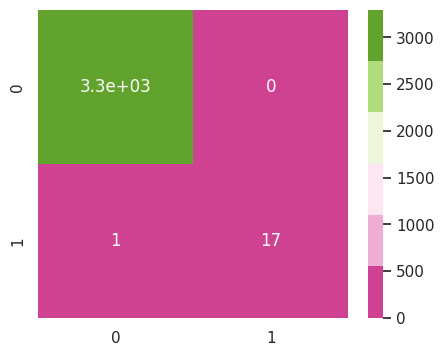

In [130]:
report_xgbc02 = classification_report(y_test, y_pred_xgbc02)
matrix_xgbc02 = confusion_matrix(y_test, y_pred_xgbc02)
cmap = sns.color_palette(palette='PiYG')
sns.heatmap(matrix_xgbc02, annot=True, cmap=cmap)
print(f' Classification report for xgbc02 :\n\n{report_xgbc02}\n')

## Model validation: ROC-AUC for rf01

In [131]:
rf01.fit(X_train, y_train)

y_pred_03_proba = rf01.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_03_proba)

auc_score = roc_auc_score(y_test, y_pred_03_proba)

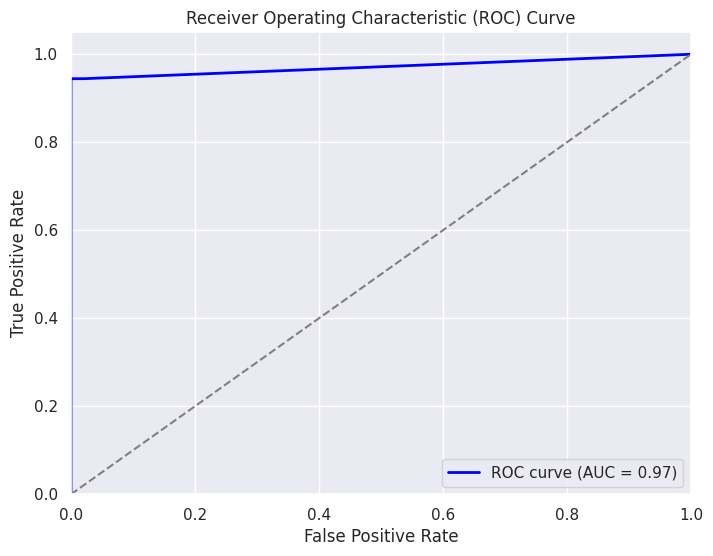

AUC Score: 0.9716491370010787


In [132]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC Score:", auc_score)

*Comment:AUC represents the area under the Receiver Operating Characteristic (ROC) curve, and as per the result as of 0.964 the model has excellent discriminative ability, with a high true positive rate and a low false positive rate, across various threshold values.*